# Intial Data Exploration
### Objectives 
---------------------------------------------------------------------
    1) Understand structure of data 
    2) Prototype variable transforms
    3) Fiddle with overly simplisctic spline fit model 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
import math
import time
%matplotlib inline  
plt.style.use('ggplot')
#load in the raw data 
df=pd.read_csv('Strategy_Data_Set.csv',parse_dates=['trial_date','subscription_date'], infer_datetime_format=True)

## Prototype variable transforms
    Lambda functions to apply to the df to calculate more columns

This kind of spoils some of my conclusions but I like to keep all of my dataframe manipulation in one cell so I don't run into
versioning issues when developing. <br>

##### <b><span style="color:red">Warning: this code might take a while to run</span></b>
<span style="color:blue">If you dont want to run this and you just want the anotated data skip this cell and uncomment the 2 lines in the cell below</span>

In [2]:
a=time.time()
print('Starting Anotation')
# add Label 
df['sub_label']=df.apply(lambda x :0 if math.isnan(x.sub_hour_start)  else 1, axis=1)
# add time values
print('Starting Time Conversion')
df['trial_dateTime']=df.apply(lambda x :x.trial_date +pd.Timedelta(x.trial_hour,'h'), axis=1) 
df['sub_dateTime']=df.apply(lambda x :x.subscription_date +pd.Timedelta(x.sub_hour_start,'h'), axis=1)   
df['subLag']=df['sub_dateTime']-df['trial_dateTime']
# add count of country for diagnostic purposes 
cTrials=df.id.groupby([df['trial_country']]).count()
df['country_count']=df.apply(lambda x :cTrials.get(x.trial_country), axis=1) 
# add country codes in 
print('Starting Country Codes')
df['us']=df.apply(lambda x : 1 if x.trial_country == 'United States' else 0,axis=1)
df['uk']=df.apply(lambda x :1 if x.trial_country == 'United Kingdom' else 0,axis=1)
df['can']=df.apply(lambda x :1 if x.trial_country == 'Canada' else 0,axis=1)
df['aus']=df.apply(lambda x :1 if x.trial_country == 'Australia' else 0,axis=1)
# add in day of the week codes 
print('Starting Day of the Week')
df['mon']=df.apply(lambda x : 1 if x.day_of_week == 'Monday' else 0,axis=1)
df['tueSun']=df.apply(lambda x :1 if x.day_of_week == 'Tuesday' or x.day_of_week == 'Sunday' else 0,axis=1)
df['wedSat']=df.apply(lambda x :1 if x.day_of_week == 'Wednesday' or x.day_of_week == 'Saturday' else 0,axis=1)
df['thr']=df.apply(lambda x :1 if x.day_of_week == 'Thursday' else 0,axis=1)
df['fri']=df.apply(lambda x :1 if x.day_of_week == 'Friday' else 0,axis=1)
b=time.time()
print ('Runtime: ' + str(b-a))
df.to_csv('Anotated_Strategy_Data_Set.csv')

Starting Anotation
Starting Time Conversion
Starting Country Codes
Starting Day of the Week
158.63948011398315


This is not insignifcant but I am running on my not very fast laptop on battery power [161.691 secs]

In [3]:
# load data from anotated csv if it is in your local directory 
df=pd.read_csv('Anotated_Strategy_Data_Set.csv',parse_dates=['trial_date','subscription_date','trial_dateTime','sub_dateTime'], infer_datetime_format=True)
# I dont think you can parse time deltas 
df['subLag']=df['sub_dateTime']-df['trial_dateTime']

In [4]:
# check for duplicate id's -> duplicate records 
print(len(df.index))
print(len(np.unique(df.id.ravel())))
# we notice there is one duplicate :( TODO: how to handle this guy 

74891
74890


In [5]:
# remove duplicate rows 
df=df.drop_duplicates('id', keep=False)

In [6]:
# check to seeif anything funky is going on with the timestamps 
df[df.trial_dateTime>df.sub_dateTime]

,Unnamed: 0,id,trial_date,trial_hour,day_of_week,trial_country,subscription_date,sub_hour_start,sub_label,trial_dateTime,...,country_count,us,uk,can,aus,mon,tueSun,wedSat,thr,fri


There are no suspicious records found here 

In [36]:
# 'null' strings avoided detection at first but after looking at the histogram I sniffed them out 
# uncoment the line below to examine the null country data 
#df[df.trial_country == 'null']

I think it is safe to leave them in.  In our currrent aproach they will be bundled into the rest of the 'rare' countries and the rest of the data seems valid.  They do seem to have  low percentage of subscribers though. 

In [8]:
if df[df.trial_date.isnull()].shape[0]+df[df.trial_hour.isnull()].shape[0]+df[df.day_of_week.isnull()].shape[0] >0:
    print ('we have some null values to chase down')

we have no null values in the rest of our columns we are assuming we have data 

## Histograms

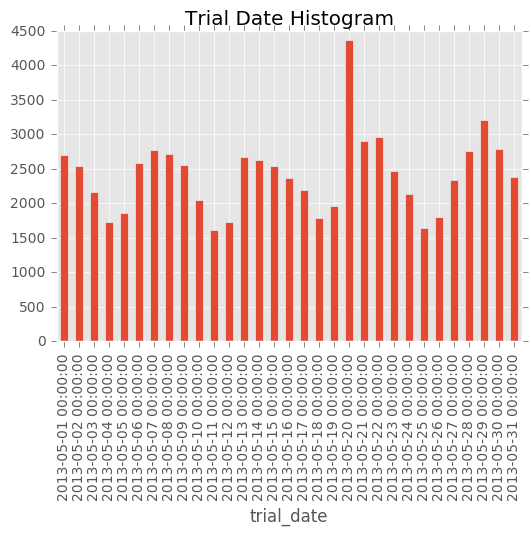

In [9]:
# lets look at some histograms of the data 
df.groupby('trial_date').size().plot(kind='bar')
pyplt.title('Trial Date Histogram')

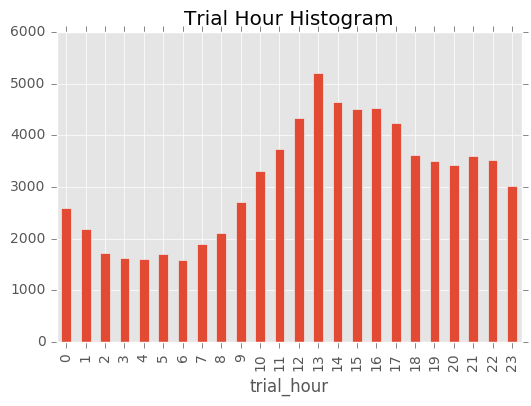

In [10]:
df.groupby('trial_hour').size().plot(kind='bar')
pyplt.title('Trial Hour Histogram')
pyplt.show()

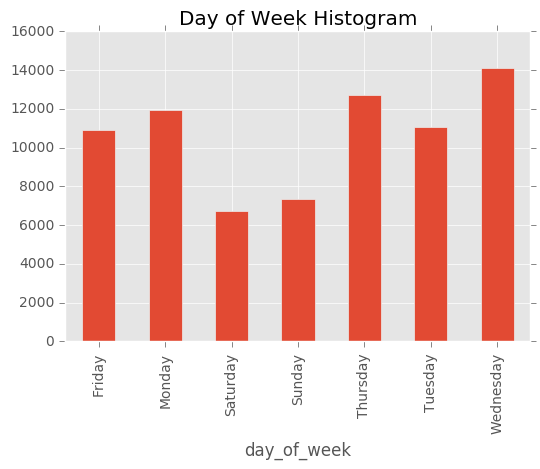

In [11]:
df.groupby('day_of_week').size().plot(kind='bar')
pyplt.title('Day of Week Histogram')
pyplt.show()

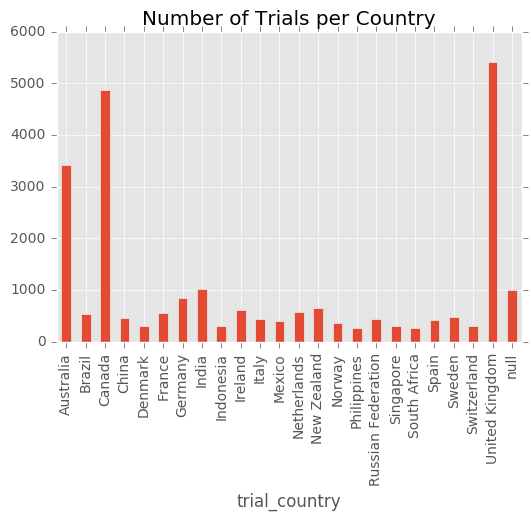

In [12]:
# i am removing us data because it makes the chart useless for all the other countries 
countrydf=df[df.trial_country!='United States'].groupby('trial_country').size() #select popular countries 
countrydf[countrydf>250].plot(kind='bar')
pyplt.title('Number of Trials per Country')
pyplt.show()
# the null values here are ~ interesting ~ 

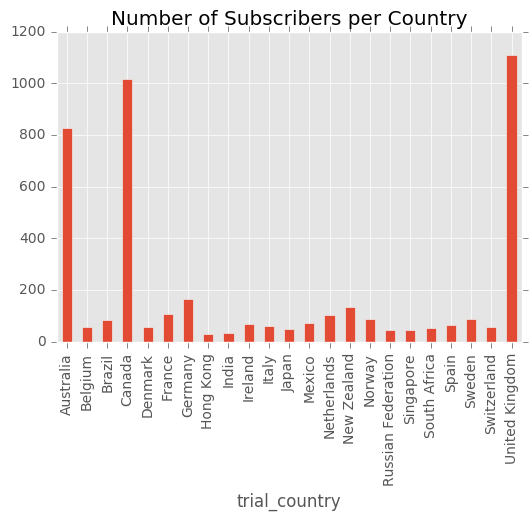

In [13]:
sdf=df[(df.subscription_date.notnull()) & (df.trial_country!='United States')]
scountrydf=sdf.groupby('trial_country').size() #select popular countries 
scountrydf[scountrydf>30].plot(kind='bar')
pyplt.title('Number of Subscribers per Country')
pyplt.show()

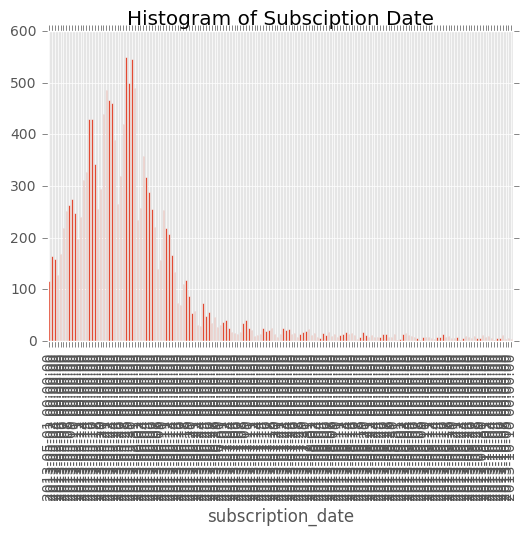

In [14]:
df.groupby('subscription_date').size().plot(kind='bar')
# this data isn't very useful we need a variable transform -> subLag
pyplt.title('Histogram of Subsciption Date')
# this is junk but generated it regardless 
pyplt.show()

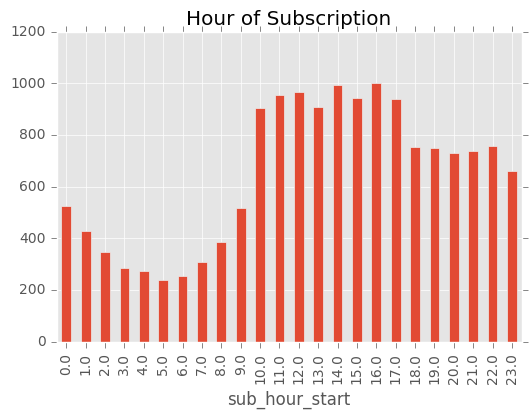

In [15]:
df.groupby('sub_hour_start').size().plot(kind='bar')
pyplt.title('Hour of Subscription')
pyplt.show()

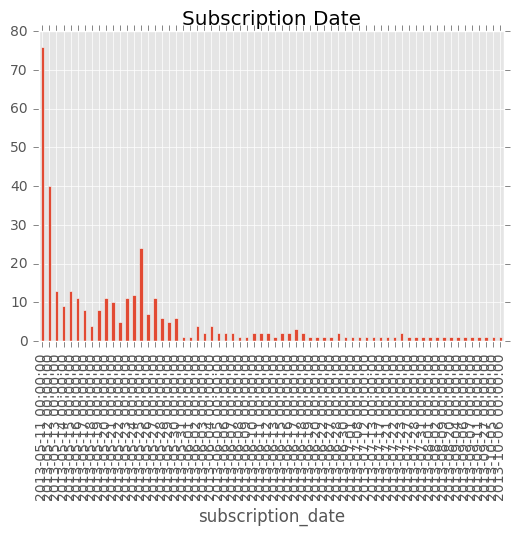

In [16]:
sample=df[df.trial_date == '5/11/2013']
ax=sample.groupby('subscription_date').size().plot(kind='bar')
pyplt.title('Subscription Date')
pyplt.show()

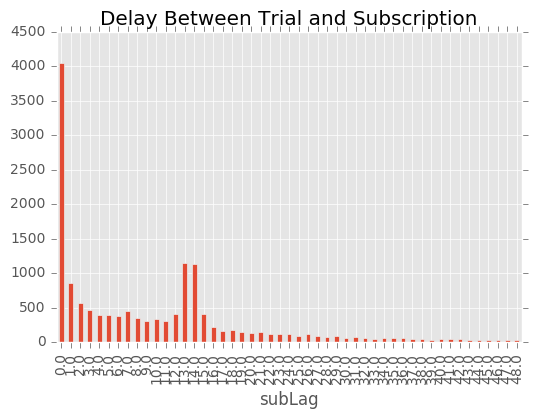

In [17]:
sdf=df[df.subLag < np.timedelta64(7,'W')]
toPlot=sdf.subLag.groupby([df.subLag.dt.days]).count()
toPlot.plot(kind="bar")
pyplt.title('Delay Between Trial and Subscription')
pyplt.show()

### Country Field Exploration 
    I am searching for the transform to expand on  this data to feed into classifiers 

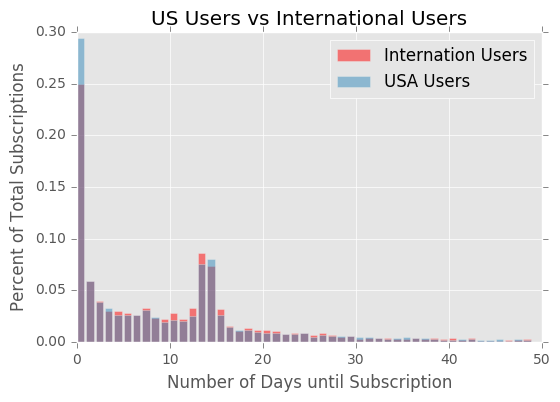

In [18]:
internationSubs=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_country!='United States')]
internationPlot=internationSubs.subLag.groupby([df.subLag.dt.days]).count()
usaSubs=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_country=='United States')]
usaPlot=usaSubs.subLag.groupby([df.subLag.dt.days]).count()
inorm=internationPlot/sum(internationPlot)
unorm=usaPlot/sum(usaPlot)
pyplt.bar(inorm.index,inorm, alpha=0.5,color='Red', label='Internation Users')
pyplt.bar(unorm.index,unorm, alpha=0.5, label='USA Users')
pyplt.title('US Users vs International Users')
pyplt.legend(loc='upper right')
pyplt.xlabel('Number of Days until Subscription')
pyplt.ylabel('Percent of Total Subscriptions')
pyplt.show()

This is an interesting discovery and indicates that US users tend to have more day 0 signups.  This means at least this variable should be in final data. 
### Lets examine other populer countries and see if they also have unique trends. 
I am going to start with the 2nd most popular country the United Kingdom 

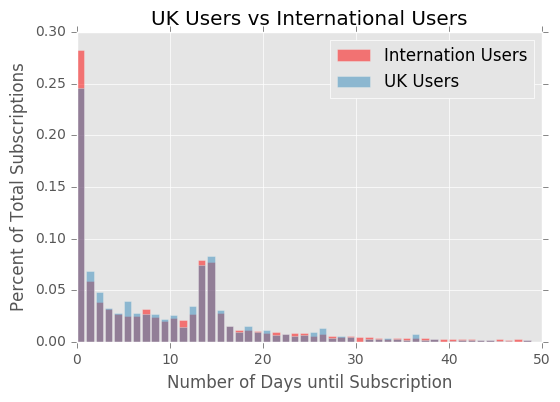

In [19]:
internationSubs=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_country!='United Kingdom')]
internationPlot=internationSubs.subLag.groupby([df.subLag.dt.days]).count()
usaSubs=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_country=='United Kingdom')]
usaPlot=usaSubs.subLag.groupby([df.subLag.dt.days]).count()
inorm=internationPlot/sum(internationPlot)
unorm=usaPlot/sum(usaPlot)
pyplt.bar(inorm.index,inorm, alpha=0.5,color='Red', label='Internation Users')
pyplt.bar(unorm.index,unorm, alpha=0.5, label='UK Users')
pyplt.title('UK Users vs International Users')
pyplt.legend(loc='upper right')
pyplt.xlabel('Number of Days until Subscription')
pyplt.ylabel('Percent of Total Subscriptions')
pyplt.show()

Interesting, it's looking like UK users look kind of like US users with a high percentage of users subscribing within 24 hours of their trial starting. Let's look at the US vs UK breakdwon to see if there are substantive differences. 

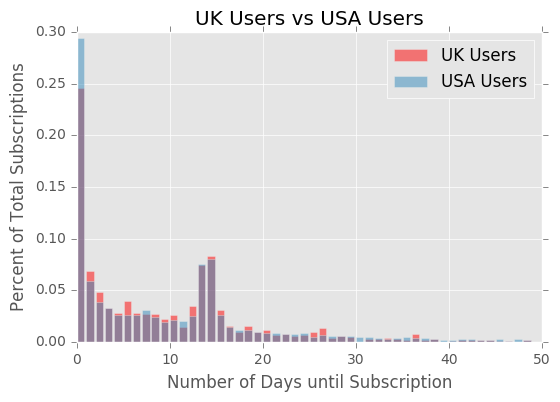

In [20]:
internationSubs=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_country=='United Kingdom')]
internationPlot=internationSubs.subLag.groupby([df.subLag.dt.days]).count()
usaSubs=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_country=='United States')]
usaPlot=usaSubs.subLag.groupby([df.subLag.dt.days]).count()
inorm=internationPlot/sum(internationPlot)
unorm=usaPlot/sum(usaPlot)
pyplt.bar(inorm.index,inorm, alpha=0.5,color='Red', label='UK Users')
pyplt.bar(unorm.index,unorm, alpha=0.5, label='USA Users')
pyplt.title('UK Users vs USA Users')
pyplt.legend(loc='upper right')
pyplt.xlabel('Number of Days until Subscription')
pyplt.ylabel('Percent of Total Subscriptions')
pyplt.show()

It looks like the USA still leads signicantly in same day subscribers
Now let's look next most popular countries canada and australia 

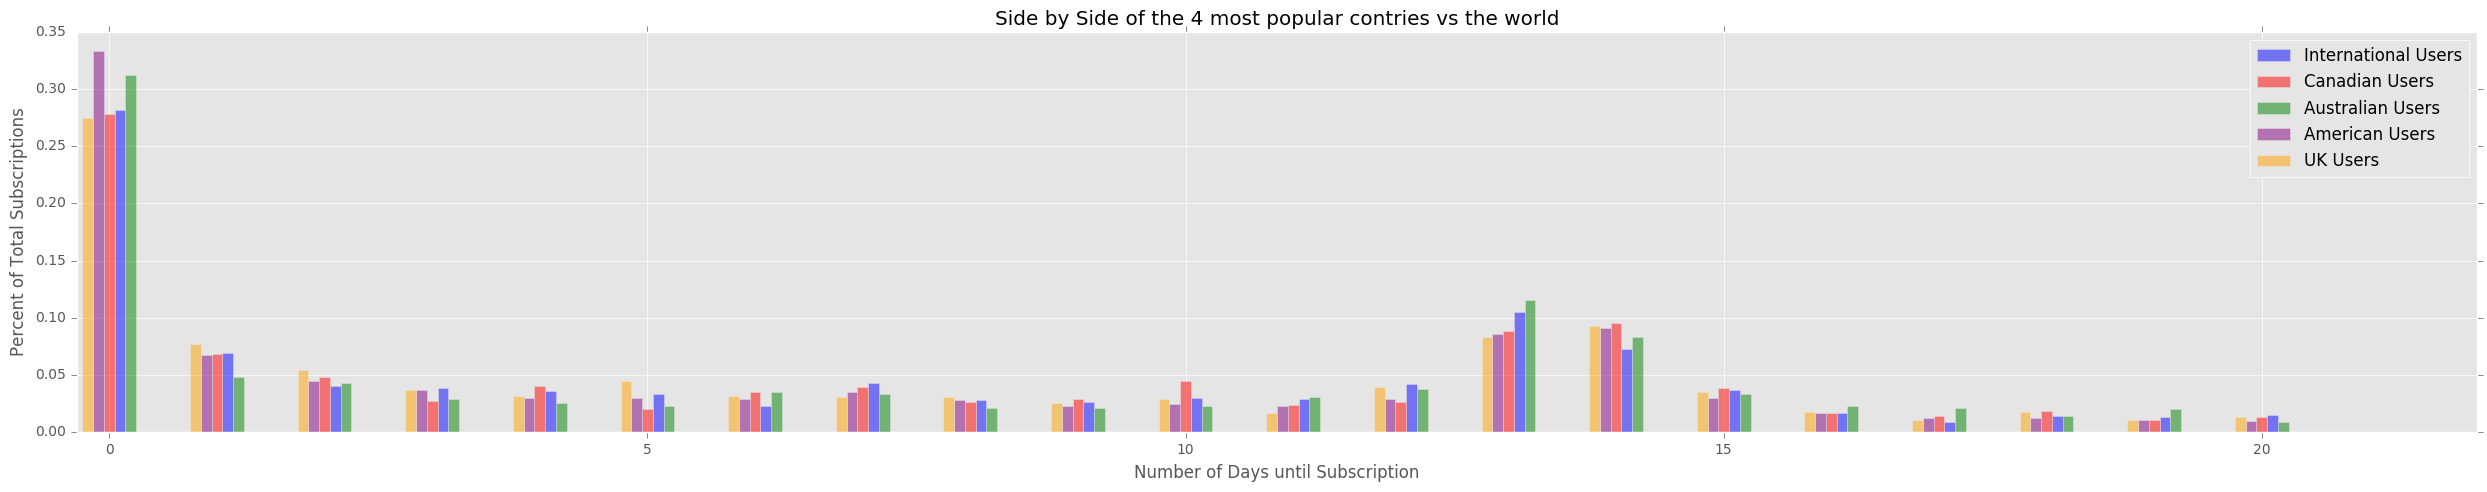

In [21]:
internationSubs=df[(df.subLag < np.timedelta64(3,'W'))&((df.trial_country!='Canada')&(df.trial_country!='Australia')&(df.trial_country!='United States')&(df.trial_country!='United Kingdom'))]
internationPlot=internationSubs.subLag.groupby([df.subLag.dt.days]).count()
canSubs=df[(df.subLag < np.timedelta64(3,'W'))&(df.trial_country=='Canada')]
canPlot=canSubs.subLag.groupby([canSubs.subLag.dt.days]).count()
ausSubs=df[(df.subLag < np.timedelta64(3,'W'))&(df.trial_country=='Australia')]
ausPlot=ausSubs.subLag.groupby([df.subLag.dt.days]).count()
usaSubs=df[(df.subLag < np.timedelta64(3,'W'))&(df.trial_country=='United States')]
usaPlot=usaSubs.subLag.groupby([df.subLag.dt.days]).count()
ukSubs=df[(df.subLag < np.timedelta64(3,'W'))&(df.trial_country=='United Kingdom')]
ukPlot=ukSubs.subLag.groupby([df.subLag.dt.days]).count()


inorm=internationPlot/sum(internationPlot)
cnorm=canPlot/sum(canPlot)
anorm=ausPlot/sum(ausPlot)
unorm=usaPlot/sum(usaPlot)
uknorm=ukPlot/sum(ukPlot)
pyplt.axes([0, 1, 4, 1])
pyplt.axis([-.3,22,0,.35])
pyplt.bar(inorm.index+.05, inorm,  width=0.1,alpha=.5, color='Blue', label='International Users')
pyplt.bar(cnorm.index-.05,    cnorm,  width=0.1,alpha=.5, color='Red', label='Canadian Users')
pyplt.bar(anorm.index+.15, anorm,  width=0.1,alpha=.5, color='Green', label='Australian Users')
pyplt.bar(unorm.index-.15, unorm,  width=0.1,alpha=.5, color='Purple', label='American Users')
pyplt.bar(uknorm.index-.25,uknorm, width=0.1,alpha=.5, color='Orange', label='UK Users')

pyplt.title('Side by Side of the 4 most popular contries vs the world')
pyplt.legend(loc='upper right')
pyplt.xlabel('Number of Days until Subscription')
pyplt.ylabel('Percent of Total Subscriptions')


pyplt.show()

For all other countries there are less than 200 subscribers and i am worried the data will get noisy. Let's see if any of them have particuarly high yeild rates or if they are all grouped together.  

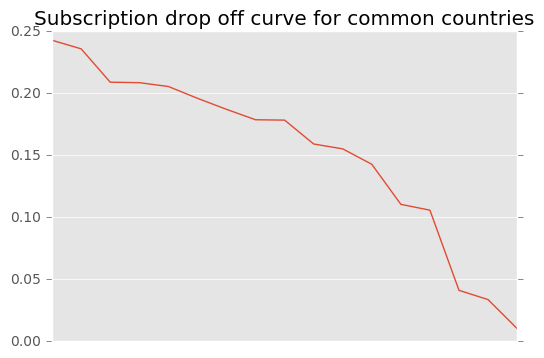

In [22]:
sdf=df[df.country_count > 400]
cTrials=sdf.id.groupby([df['trial_country']]).count()
cSubs=sdf.subLag.groupby([df['trial_country']]).count()
cTrials2=df.id.groupby([df['trial_country']]).count()
cSub2=df.subLag.groupby([df['trial_country']]).count()
ratio=(cSubs/cTrials).sort_values(ascending=0)
#print(ratio)
a=ratio.plot()
a.set_title('Subscription drop off curve for significant countries')
a.axes.get_xaxis().set_visible(False)
a.set_title('Subscription drop off curve for common countries')

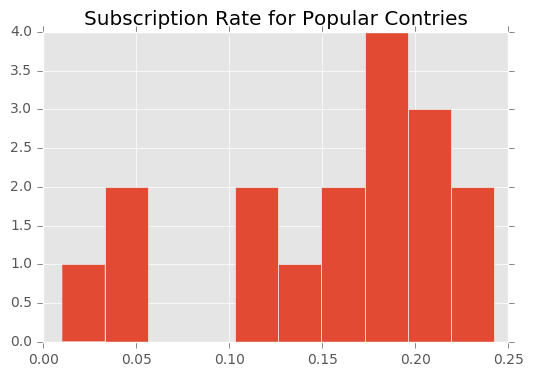

In [23]:
ratio.hist()
pyplt.title('Subscription Rate for Popular Contries')
pyplt.show()

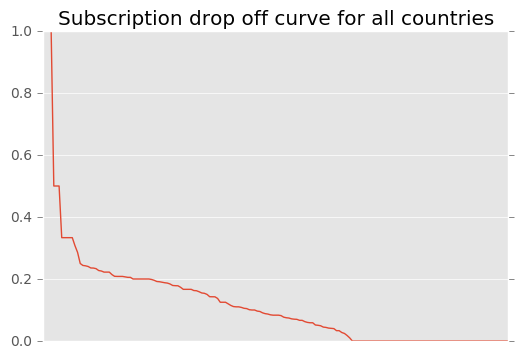

In [24]:
ratio=(cSub2/cTrials2).sort_values(ascending=0)
#print(ratio)
a=ratio.plot()
a.axes.get_xaxis().set_visible(False)
a.set_title('Subscription drop off curve for all countries')

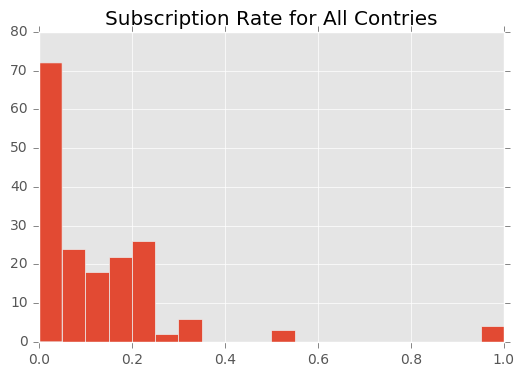

In [25]:
ratio.hist(bins=20)
pyplt.title('Subscription Rate for All Contries')
pyplt.show()

My decision is to issue the top four contries and leave the rest with indicator varaible as i believe that sample size is not large enough to add them into the dataset as is.  It might be possible to group them by continent or similar groupings to make the sample size significant.  This might be revisited if I am unhappy with the model results. <br>
<tab> Link to Python Package to help with this: https://pypi.python.org/pypi/incf.countryutils


### Day of the Week 
    my goal is to determine how to handle the day of the week, and what (if any) indicator variables should be added. 

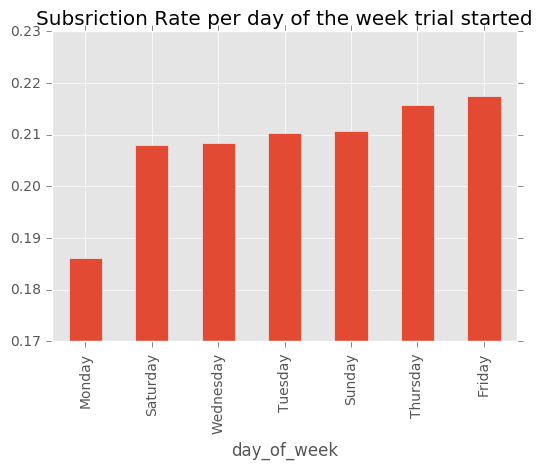

In [26]:
(df.sub_dateTime.groupby(df.day_of_week).count()/df.trial_date.groupby(df.day_of_week).count()).sort_values().plot(kind='bar')
pyplt.title('Subsriction Rate per day of the week trial started')
pyplt.axis([-.5,6.5,.17,.23])
pyplt.show()

From this chart Monday should definetly have it's own variable.  Now the other pairings get interesting.  There seems to be 5 groupings: 
<ul>
<li>1) Monday  </li>
<li>2) Tuesday and Sunday     : 0.00036 apart </li>
<li>3) Saturday and Wednesday : 0.00041 </li>
<li>4) Thursday </li>
<li>5) Friday </li>
</ul>

We could attempt formal hypothesis testing to confirm this my gut is saying it might be better to just lump them all in. 

In [27]:
#Way to do the calculation 
a=(df.sub_dateTime.groupby(df.day_of_week).count()/df.trial_date.groupby(df.day_of_week).count()).sort_values()
abs(a['Thursday']-a['Friday'])

0.001855981639032861

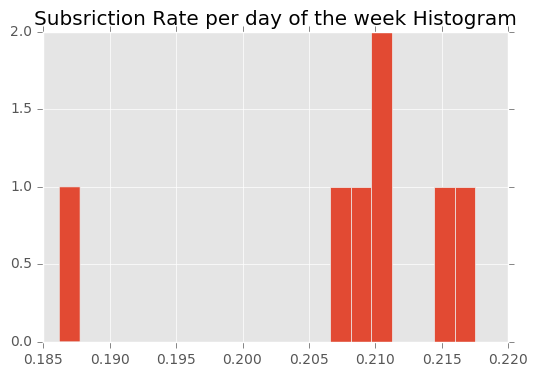

---  Data Dump  ---
day_of_week
Monday       0.186208
Saturday     0.207963
Wednesday    0.208375
Tuesday      0.210274
Sunday       0.210777
Thursday     0.215679
Friday       0.217535
dtype: float64


In [28]:
(df.sub_dateTime.groupby(df.day_of_week).count()/df.trial_date.groupby(df.day_of_week).count()).hist(bins=20)
pyplt.title('Subsriction Rate per day of the week Histogram')
pyplt.show()
print('---  Data Dump  ---')
print((df.sub_dateTime.groupby(df.day_of_week).count()/df.trial_date.groupby(df.day_of_week).count()).sort_values())

## 3) Cubic Spline Model
    This is a naive atempt at a fit.  It has a lot of issues just trying to see how 'simple' we can get away with

In [29]:
from scipy.interpolate import interp1d
x=range(0,len(toPlot.values))
f = interp1d(x, toPlot.values,kind='cubic')
ynew = f(x)

27.573269514
Estimate
524.493477013
Actual
533
Normed
0.984040294583


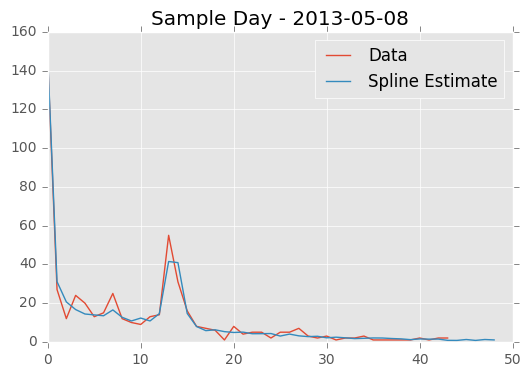

In [30]:
tDate='2013-05-08'
sdf=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_date == np.datetime64(tDate))]
# scale factor calc 
scaleFactor=df.count()[0]/df[df.trial_date == np.datetime64(tDate)].count()[0]
print(scaleFactor)
toPlot=sdf.subLag.groupby([df.subLag.dt.days]).count()
x2=range(0,len(toPlot.values))
pyplt.plot(x2,toPlot.values,x, ynew/scaleFactor)
pyplt.title('Sample Day - '+str(tDate))
pyplt.legend(["Data", "Spline Estimate"])
print('Estimate')
a=sum(ynew/scaleFactor)
print(a)
print('Actual')
b=sum(sdf.subLag.groupby([df.subLag.dt.days]).count())
print(b)
print('Normed')
print(1-abs(a-b)/b)

In [31]:
arr=[]
for i in range (1,30):
    if i < 10:
        tDate='2013-05-0'+str(i)
    else:
        tDate='2013-05-'+str(i)
    sdf=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_date == np.datetime64(tDate))]
    # scale factor calc 
    scaleFactor=df.count()[0]/df[df.trial_date == np.datetime64(tDate)].count()[0]
    #print(scaleFactor)
    toPlot=sdf.subLag.groupby([df.subLag.dt.days]).count()
    x2=range(0,len(toPlot.values))
    #pyplt.plot(x2,toPlot.values,x, ynew/scaleFactor, '-')
    a=sum(ynew/scaleFactor)
    b=sum(sdf.subLag.groupby([df.subLag.dt.days]).count())
    ratio = 1-abs(a-b)/b
    arr.append(ratio)
    if ratio <.5: 
        print (tDate)
print (sum(arr)/len(arr))



2013-05-20
0.933398444756


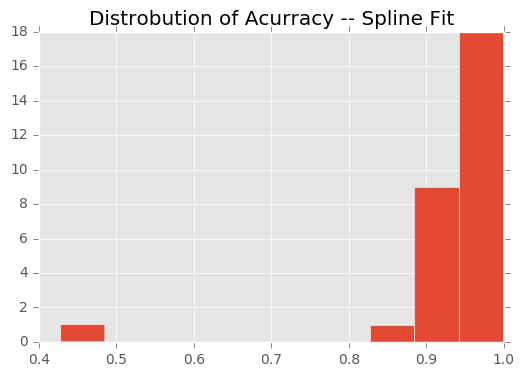

In [32]:
pyplt.hist(arr)
pyplt.title('Distrobution of Acurracy -- Spline Fit')
pyplt.show()

In [33]:
print (arr[19]) # this is a significant outlier lets look at it 

0.428078880126


Estimate
842.549720253
Actual
536
Normed
0.428078880126


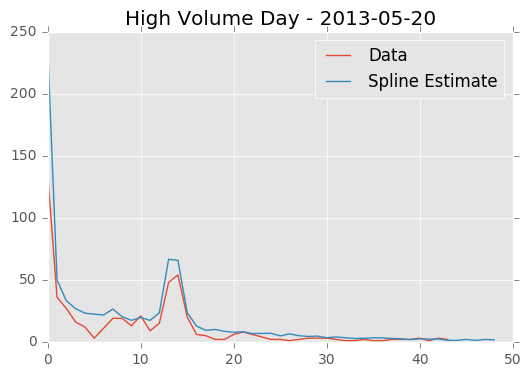

In [34]:
tDate='2013-05-20'
sdf=df[(df.subLag < np.timedelta64(7,'W'))&(df.trial_date == np.datetime64(tDate))]
# scale factor calc 
scaleFactor=df.count()[0]/df[df.trial_date == np.datetime64(tDate)].count()[0]
#print(scaleFactor)
toPlot=sdf.subLag.groupby([df.subLag.dt.days]).count()
x2=range(0,len(toPlot.values))
pyplt.plot(x2,toPlot.values,x, ynew/scaleFactor)
pyplt.title('High Volume Day - '+str(tDate))
pyplt.legend(["Data", "Spline Estimate"])
print('Estimate')
a=sum(ynew/scaleFactor)
print(a)
print('Actual')
b=sum(sdf.subLag.groupby([df.subLag.dt.days]).count())
print(b)
print('Normed')
print(1-abs(a-b)/b)

We can see here what is causing our prediction to fail. we are getting an abnormaly large spike in users signing up for trials with roughly the same number subscribing causing the simple spline fit to whiff pretty badly here. 

In [38]:
sampleDf=df.sample(1000)
sampleDf.to_csv('Sample_Strategy_Data_Set.csv')